# ORF recognition by Convolutional/Recurrent

Based on ORF_CNN_118 but model is now CNN+GRU. Specifically 2x16 CNN and 2x16 GRU and 1x16 Dense. Use a much larger training set and many more epochs. Achieve 97.5% accuracy.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-17 16:34:07 UTC'

In [2]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=36            # how long is each sequence
CDS_LEN=18            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
CELLS = 16
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=50  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import ORF_counter
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
import random
def partition_random_sequences(goal_per_class):
    pc_seqs=[]
    nc_seqs=[]
    oc = ORF_counter()
    trials = 0
    pc_cnt = 0
    nc_cnt = 0
    bases=['A','C','G','T']
    while pc_cnt<goal_per_class or nc_cnt<goal_per_class:
        trials += 1        
        between_bases = random.randint(0,RNA_LEN-6) 
        utr5_bases = (RNA_LEN - (between_bases + 6)) // 2
        utr3_bases = RNA_LEN - (utr5_bases + (between_bases+6))
        one_seq  = "".join(random.choices(bases,k=utr5_bases)) 
        one_seq += 'ATG'    
        one_seq += "".join(random.choices(bases,k=between_bases)) 
        random_stop = random.choice(['TAA','TAG','TGA']) # random frame
        one_seq += random_stop
        one_seq += "".join(random.choices(bases,k=utr3_bases))  
        if len(one_seq) != RNA_LEN:
            print("WRONG LENGTH:",len(one_seq),utr5_bases,between_bases,utr3_bases)
        oc.set_sequence(one_seq)
        cds_len = oc.get_max_cds_len() + 3
        if cds_len >= CDS_LEN and pc_cnt<goal_per_class:
            pc_cnt += 1
            pc_seqs.append(one_seq)
        elif cds_len < CDS_LEN and nc_cnt<goal_per_class:
            nc_cnt += 1
            nc_seqs.append(one_seq)
    print ("It took %d trials to reach %d per class."%(trials,goal_per_class))
    return pc_seqs,nc_seqs
pc_all,nc_all=partition_random_sequences(10)  # just testing
pc_all,nc_all=partition_random_sequences(PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 33 trials to reach 10 per class.
It took 92267 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 36.0
Average ORF length: 20.012
NC seqs
Average RNA length: 36.0
Average ORF length: 2.0038181818181817


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(GRU(CELLS,return_sequences=True))
    dnn.add(GRU(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (36, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 36, 16)            208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 16)            0         
_________________________________________________________________
gru (GRU)                    (None, 18, 16)            1632      
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                1632      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dropout (Dropout)         

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 29s 8ms/step - loss: 0.6983 - accuracy: 0.5284 - val_loss: 0.6455 - val_accuracy: 0.6159


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6436 - accuracy: 0.6174 - val_loss: 0.6139 - val_accuracy: 0.6225


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6179 - accuracy: 0.6304 - val_loss: 0.5995 - val_accuracy: 0.6321


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5991 - accuracy: 0.6418 - val_loss: 0.5912 - val_accuracy: 0.6445


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5931 - accuracy: 0.6545 - val_loss: 0.5828 - val_accuracy: 0.6811


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5851 - accuracy: 0.6790 - val_loss: 0.5760 - val_accuracy: 0.6898


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5756 - accuracy: 0.6914 - val_loss: 0.5654 - val_accuracy: 0.6988


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5661 - accuracy: 0.7037 - val_loss: 0.5554 - val_accuracy: 0.7108


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5615 - accuracy: 0.7088 - val_loss: 0.5496 - val_accuracy: 0.7168


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 10/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5534 - accuracy: 0.7182 - val_loss: 0.5366 - val_accuracy: 0.7302


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5381 - accuracy: 0.7334 - val_loss: 0.5173 - val_accuracy: 0.7428


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.5163 - accuracy: 0.7468 - val_loss: 0.5102 - val_accuracy: 0.7424
Epoch 13/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4986 - accuracy: 0.7624 - val_loss: 0.4701 - val_accuracy: 0.7751


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 14/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4694 - accuracy: 0.7809 - val_loss: 0.4524 - val_accuracy: 0.7897


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 15/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.4509 - accuracy: 0.7919 - val_loss: 0.4397 - val_accuracy: 0.7924


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 16/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4357 - accuracy: 0.8008 - val_loss: 0.4156 - val_accuracy: 0.8109


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.4197 - accuracy: 0.8113 - val_loss: 0.4027 - val_accuracy: 0.8159


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4057 - accuracy: 0.8213 - val_loss: 0.3870 - val_accuracy: 0.8219


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.4029 - accuracy: 0.8218 - val_loss: 0.3997 - val_accuracy: 0.8134
Epoch 20/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.3810 - accuracy: 0.8302 - val_loss: 0.3736 - val_accuracy: 0.8330


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3637 - accuracy: 0.8415 - val_loss: 0.3573 - val_accuracy: 0.8441


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3427 - accuracy: 0.8504 - val_loss: 0.3332 - val_accuracy: 0.8501


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3304 - accuracy: 0.8581 - val_loss: 0.3482 - val_accuracy: 0.8447
Epoch 24/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3259 - accuracy: 0.8585 - val_loss: 0.3210 - val_accuracy: 0.8566


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3159 - accuracy: 0.8646 - val_loss: 0.3101 - val_accuracy: 0.8625


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 26/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.3030 - accuracy: 0.8688 - val_loss: 0.3044 - val_accuracy: 0.8682


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2921 - accuracy: 0.8753 - val_loss: 0.3058 - val_accuracy: 0.8673
Epoch 28/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2920 - accuracy: 0.8755 - val_loss: 0.2828 - val_accuracy: 0.8759


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2813 - accuracy: 0.8835 - val_loss: 0.2976 - val_accuracy: 0.8737
Epoch 30/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2789 - accuracy: 0.8834 - val_loss: 0.2757 - val_accuracy: 0.8812


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2645 - accuracy: 0.8912 - val_loss: 0.2733 - val_accuracy: 0.8832


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2661 - accuracy: 0.8891 - val_loss: 0.2773 - val_accuracy: 0.8861


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2569 - accuracy: 0.8927 - val_loss: 0.2737 - val_accuracy: 0.8821
Epoch 34/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2527 - accuracy: 0.8968 - val_loss: 0.2658 - val_accuracy: 0.8869


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2475 - accuracy: 0.8993 - val_loss: 0.2581 - val_accuracy: 0.8946


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2439 - accuracy: 0.9005 - val_loss: 0.2626 - val_accuracy: 0.8894
Epoch 37/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2338 - accuracy: 0.9055 - val_loss: 0.2544 - val_accuracy: 0.8925
Epoch 38/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2281 - accuracy: 0.9077 - val_loss: 0.2359 - val_accuracy: 0.9020


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2206 - accuracy: 0.9118 - val_loss: 0.2429 - val_accuracy: 0.9022


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2176 - accuracy: 0.9123 - val_loss: 0.2277 - val_accuracy: 0.9062


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 41/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2052 - accuracy: 0.9183 - val_loss: 0.2360 - val_accuracy: 0.9057
Epoch 42/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.2066 - accuracy: 0.9162 - val_loss: 0.2305 - val_accuracy: 0.9023
Epoch 43/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.2025 - accuracy: 0.9172 - val_loss: 0.2236 - val_accuracy: 0.9098


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 44/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1916 - accuracy: 0.9260 - val_loss: 0.2225 - val_accuracy: 0.9105


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 45/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1948 - accuracy: 0.9229 - val_loss: 0.2107 - val_accuracy: 0.9152


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1851 - accuracy: 0.9274 - val_loss: 0.2164 - val_accuracy: 0.9140
Epoch 47/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1868 - accuracy: 0.9253 - val_loss: 0.2239 - val_accuracy: 0.9114
Epoch 48/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1865 - accuracy: 0.9258 - val_loss: 0.2391 - val_accuracy: 0.9095
Epoch 49/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1898 - accuracy: 0.9290 - val_loss: 0.2070 - val_accuracy: 0.9170


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 50/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.1766 - accuracy: 0.9319 - val_loss: 0.2118 - val_accuracy: 0.9169
Fold 1, 50 epochs, 758 sec


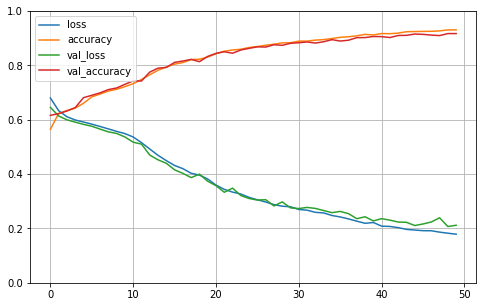

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 13s 8ms/step - loss: 0.6969 - accuracy: 0.5341 - val_loss: 0.6369 - val_accuracy: 0.6258
Epoch 2/50
1334/1334 [==============================] - 9s 7ms/step - loss: 0.6361 - accuracy: 0.6237 - val_loss: 0.6276 - val_accuracy: 0.6234
Epoch 3/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.6199 - accuracy: 0.6328 - val_loss: 0.6013 - val_accuracy: 0.6361
Epoch 4/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.6017 - accuracy: 0.6419 - val_loss: 0.5701 - val_accuracy: 0.6616
Epoch 5/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5648 - accuracy: 0.6791 - val_loss: 0.5298 - val_accuracy: 0.7135
Epoch 6/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5196 - accuracy: 0.7322 - val_loss: 0.4659 - val_accuracy: 0.7781
Epoch 7/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.4525 - accur

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 15/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1733 - accuracy: 0.9302 - val_loss: 0.1500 - val_accuracy: 0.9392


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 16/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1490 - accuracy: 0.9383 - val_loss: 0.1188 - val_accuracy: 0.9482


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1489 - accuracy: 0.9369 - val_loss: 0.2986 - val_accuracy: 0.8745
Epoch 18/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.3409 - accuracy: 0.8520 - val_loss: 0.1309 - val_accuracy: 0.9488


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1299 - accuracy: 0.9483 - val_loss: 0.0979 - val_accuracy: 0.9570


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1052 - accuracy: 0.9552 - val_loss: 0.0936 - val_accuracy: 0.9587


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1066 - accuracy: 0.9542 - val_loss: 0.0866 - val_accuracy: 0.9601


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1932 - accuracy: 0.9251 - val_loss: 0.1240 - val_accuracy: 0.9488
Epoch 23/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1035 - accuracy: 0.9567 - val_loss: 0.0806 - val_accuracy: 0.9625


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 24/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0822 - accuracy: 0.9622 - val_loss: 0.0832 - val_accuracy: 0.9585
Epoch 25/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0794 - accuracy: 0.9632 - val_loss: 0.0739 - val_accuracy: 0.9625
Epoch 26/50
1334/1334 [==============================] - 10s 8ms/step - loss: 0.0864 - accuracy: 0.9633 - val_loss: 0.0746 - val_accuracy: 0.9639


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0769 - accuracy: 0.9635 - val_loss: 0.1338 - val_accuracy: 0.9460
Epoch 28/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0973 - accuracy: 0.9590 - val_loss: 0.0731 - val_accuracy: 0.9640


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0758 - accuracy: 0.9652 - val_loss: 0.0671 - val_accuracy: 0.9643


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 30/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0673 - accuracy: 0.9660 - val_loss: 0.1340 - val_accuracy: 0.9501
Epoch 31/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0713 - accuracy: 0.9665 - val_loss: 0.0723 - val_accuracy: 0.9662


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0756 - accuracy: 0.9662 - val_loss: 0.0670 - val_accuracy: 0.9673


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0740 - accuracy: 0.9666 - val_loss: 0.0648 - val_accuracy: 0.9668
Epoch 34/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0620 - accuracy: 0.9694 - val_loss: 0.0616 - val_accuracy: 0.9678


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0680 - accuracy: 0.9667 - val_loss: 0.0606 - val_accuracy: 0.9697


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0650 - accuracy: 0.9693 - val_loss: 0.0675 - val_accuracy: 0.9672
Epoch 37/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0692 - accuracy: 0.9677 - val_loss: 0.0639 - val_accuracy: 0.9702


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 38/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0583 - accuracy: 0.9713 - val_loss: 0.0730 - val_accuracy: 0.9654
Epoch 39/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0593 - accuracy: 0.9706 - val_loss: 0.0650 - val_accuracy: 0.9695
Epoch 40/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0754 - accuracy: 0.9685 - val_loss: 0.0572 - val_accuracy: 0.9713


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 41/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0591 - accuracy: 0.9708 - val_loss: 0.0582 - val_accuracy: 0.9707
Epoch 42/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0573 - accuracy: 0.9733 - val_loss: 0.0582 - val_accuracy: 0.9728


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0501 - accuracy: 0.9760 - val_loss: 0.0538 - val_accuracy: 0.9752


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 44/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0561 - accuracy: 0.9742 - val_loss: 0.0662 - val_accuracy: 0.9698
Epoch 45/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0522 - accuracy: 0.9748 - val_loss: 0.0539 - val_accuracy: 0.9756


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0520 - accuracy: 0.9751 - val_loss: 0.0593 - val_accuracy: 0.9728
Epoch 47/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0496 - accuracy: 0.9767 - val_loss: 0.1120 - val_accuracy: 0.9588
Epoch 48/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0611 - accuracy: 0.9724 - val_loss: 0.0635 - val_accuracy: 0.9737
Epoch 49/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.0565 - accuracy: 0.9731 - val_loss: 0.0505 - val_accuracy: 0.9760


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 50/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.1060 - accuracy: 0.9627 - val_loss: 0.0562 - val_accuracy: 0.9752
Fold 2, 50 epochs, 639 sec


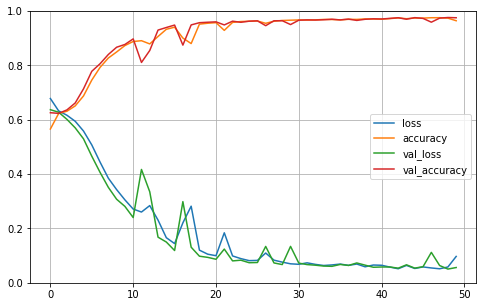

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/50
1334/1334 [==============================] - 14s 8ms/step - loss: 0.7142 - accuracy: 0.5068 - val_loss: 0.6512 - val_accuracy: 0.6127
Epoch 2/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.6496 - accuracy: 0.6124 - val_loss: 0.6141 - val_accuracy: 0.6191
Epoch 3/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.6152 - accuracy: 0.6265 - val_loss: 0.6001 - val_accuracy: 0.6244
Epoch 4/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.6029 - accuracy: 0.6308 - val_loss: 0.5870 - val_accuracy: 0.6322
Epoch 5/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5879 - accuracy: 0.6464 - val_loss: 0.5692 - val_accuracy: 0.6671
Epoch 6/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5706 - accuracy: 0.6691 - val_loss: 0.5643 - val_accuracy: 0.6707
Epoch 7/50
1334/1334 [==============================] - 10s 7ms/step - loss: 0.5601 - accu

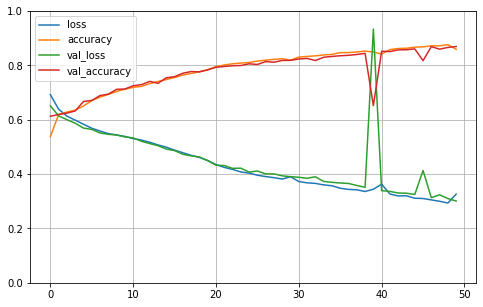

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 97.50%


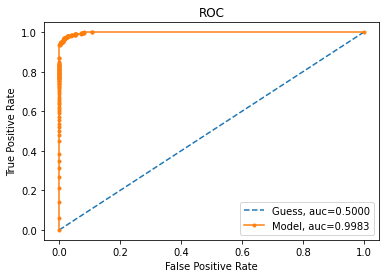

AUC: 99.83%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-17 17:06:05 UTC'